In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

2023-08-17 01:16:08.021754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-17 01:16:08.601863: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-17 01:16:08.603486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 01:16:10.913246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Simpler dataset

In [72]:
df_train = pd.read_csv("emotion_train.txt",sep=";",
    names=["Description","Emotion"])
df_test = pd.read_csv("emotion_test.txt",sep=";",
    names=["Description","Emotion"])
df_val = pd.read_csv("emotion_val.txt",sep=";",
    names=["Description","Emotion"])

In [133]:
# Classes and their counts
np.unique(np.array(df_train['Emotion']), return_counts=True)

(array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype=object),
 array([2089, 1888, 5258, 1282, 4553,  563]))

In [134]:
pd.DataFrame(np.unique(np.array(df_train['Emotion']), return_counts=True))

,0,1,2,3,4,5
0,anger,fear,joy,love,sadness,surprise
1,2089,1888,5258,1282,4553,563


In [75]:


# Download necessary NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load your tabular data into a pandas DataFrame
# Assuming your data is in a CSV file, replace 'data.csv' with your file path
# data = pd.read_csv('data.csv')

# Define a function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Apply stemming or lemmatization (choose one)
    # Stemming reduces words to their root form (e.g., running -> run)
    # ps = PorterStemmer()
    # words = [ps.stem(word) for word in words]

    # Lemmatization reduces words to their base or dictionary form (e.g., running -> run)
    lemma = WordNetLemmatizer()
    words = [lemma.lemmatize(word) for word in words]

    # If the count of words is less than 3, then give it an empty list(To delete that rows later)
    if len(words) < 3:
      words = []

    # Join the words back into a single string
    preprocessed_text = ' '.join(words)
    return preprocessed_text
    # return text

# Apply the preprocessing function to the 'text' column in the DataFrame
df_train['preprocessed_text'] = df_train['Description'].apply(preprocess_text)
df_test['preprocessed_text'] = df_test['Description'].apply(preprocess_text)
df_val['preprocessed_text'] = df_val['Description'].apply(preprocess_text)

# Save the preprocessed data to a new CSV file (optional)
# data.to_csv('preprocessed_data.csv', index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     /home/ruben_ghazaryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ruben_ghazaryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ruben_ghazaryan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
pd.set_option('display.max_colwidth', None)

In [80]:
    # if len(words) < 3:
    #   words = []
df_train = df_train.loc[df_train['preprocessed_text'] != '']
df_val = df_val.loc[df_val['preprocessed_text'] != '']
df_test = df_test.loc[df_test['preprocessed_text'] != '']


### Deleting the duplicate rows.

In [81]:
index = df_train[df_train['preprocessed_text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

/tmp/ipykernel_3828/2953887364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(index, axis = 0, inplace = True)


In [82]:
index = df_val[df_val['preprocessed_text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [83]:
index = df_test[df_test['preprocessed_text'].duplicated() == True].index
df_test.drop(index, axis = 0, inplace = True)
df_test.reset_index(inplace=True, drop = True)

In [84]:
df_train.shape

(15633, 3)

In [85]:
X_train = df_train['preprocessed_text']
X_val = df_val['preprocessed_text']
X_test = df_test['preprocessed_text']

In [22]:
X_train.shape

(7845,)

# Tokenization

In [86]:


import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


In [87]:
max_voc_size = len(set(X_train.sum().split()))
max_seq_len = X_train.apply(lambda x: len(x.split())).max()
max_voc_size, max_seq_len

(23906, 35)

In [88]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_seq_len)


In [89]:
val_sequences = tokenizer.texts_to_sequences(X_val)
val_sequences_padded = pad_sequences(val_sequences, maxlen=max_seq_len)

In [135]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_seq_len)

In [136]:
train_sequences_padded.shape, test_sequences_padded.shape

((15633, 35), (1967, 35))

In [139]:
len(tokenizer.word_index)

13473

In [140]:
y_train = df_train['Emotion']
y_val = df_val['Emotion']
y_test = df_test['Emotion']
y_train.unique(), y_train.shape

(array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
       dtype=object),
 (15633,))

In [141]:
# Making the classes numeric, maybe useful
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label encode your non-numeric classes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [142]:
np.unique(np.array(y_train), return_counts=True)

(array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype=object),
 array([2089, 1888, 5258, 1282, 4553,  563]))

In [143]:
np.unique(y_train_encoded)

array([0, 1, 2, 3, 4, 5])

In [94]:
vocabSize = len(tokenizer.index_word) + 1


In [95]:

num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [144]:
# Upload the file to Colab and get its path
uploaded_file_path = 'glove.twitter.27B.200d.txt'  # Change this to the actual path

# Initialize an embeddings_index dictionary
embeddings_index = {}

# Open and read the GloVe embeddings file
with open(uploaded_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Now you can use embeddings_index to access the pre-trained word vectors.
# For example:
embedding_vector = embeddings_index.get('word')


In [97]:
# Read word vectors
with open(uploaded_file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 1193514 word vectors.
Converted 12601 words (872 misses)


In [145]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [146]:
y_train_encoded
y_val_encoded

array([4, 4, 3, ..., 2, 2, 2])

In [124]:
model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=train_sequences_padded.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

In [125]:
train_sequences_padded.shape[1]

35

In [129]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
train_sequences_padded.shape, y_train.shape, val_sequences_padded.shape, y_val.shape

((15633, 35), (15633,), (1962, 35), (1962,))

In [132]:
model.fit(train_sequences_padded, y_train_encoded, epochs=10, validation_data=(val_sequences_padded, y_val_encoded), batch_size=256)

Epoch 1/10
62/62 [==============================] - 151s 2s/step - loss: 0.1187 - accuracy: 0.9477 - val_loss: 0.1745 - val_accuracy: 0.9327
Epoch 2/10
62/62 [==============================] - 125s 2s/step - loss: 0.1090 - accuracy: 0.9530 - val_loss: 0.1566 - val_accuracy: 0.9281
Epoch 3/10
62/62 [==============================] - 126s 2s/step - loss: 0.0927 - accuracy: 0.9586 - val_loss: 0.1650 - val_accuracy: 0.9302
Epoch 4/10
62/62 [==============================] - 125s 2s/step - loss: 0.0841 - accuracy: 0.9646 - val_loss: 0.1783 - val_accuracy: 0.9241
Epoch 5/10
62/62 [==============================] - 125s 2s/step - loss: 0.0787 - accuracy: 0.9628 - val_loss: 0.1708 - val_accuracy: 0.9327
Epoch 6/10
62/62 [==============================] - 124s 2s/step - loss: 0.0723 - accuracy: 0.9695 - val_loss: 0.1767 - val_accuracy: 0.9251
Epoch 7/10
62/62 [==============================] - 127s 2s/step - loss: 0.0736 - accuracy: 0.9687 - val_loss: 0.1929 - val_accuracy: 0.9292
Epoch 8/10
62

# Model

In [ ]:
# Just a draft

# from gensim.models import Word2Vec
# from keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPooling1D, Dropout
# from keras.models import Sequential
# import numpy as np

# # Assuming you have tokenized train_texts
# model = Word2Vec(sentences=train_sequences_paddedd, vector_size=100, window=5, min_count=1, sg=0)

# embedding_matrix = np.zeros((len(model.wv.index_to_key) + 1, 100))
# for i, word in enumerate(model.wv.index_to_key):
#     embedding_matrix[i] = model.wv[word]

Exception in thread Thread-10 (_worker_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-11 (_worker_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-12 (_worker_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/word2vec.py", line 1166, in _worker_loop
    tally, raw_tally = self._do_train_job(data_iterable, alpha, thread_private_mem)
  File "/usr/local/lib/python3.10/dist-packages/gensim/models/word2vec.py", line 957, in _do_train_job
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  F

In [159]:
# Trying to create efficent model

from keras.layers import Bidirectional, GlobalMaxPooling1D, Dropout

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_seq_len))

# model.add(tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
#                                     output_dim=embedding_matrix.shape[1],
#                                     weights=[embedding_matrix],
#                                     input_length=max_seq_len,
#                                     trainable=False))

# Bidirectional LSTM layers
# model.add(Bidirectional(LSTM(512, return_sequences=True)))
# model.add(Bidirectional(LSTM(256, return_sequences=True)))

# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))

model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))

# Global Max Pooling layer
# model.add(GlobalMaxPooling1D())

# Dropout layer for regularization
model.add(Dropout(0.2))

# Dense layer with softmax activation for classification
model.add(Dense(2, activation='sigmoid')) , # should be changed if number of classes > 2

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 21, 100)           500000    
                                                                 
 bidirectional_38 (Bidirecti  (None, 21, 512)          731136    
 onal)                                                           
                                                                 
 bidirectional_39 (Bidirecti  (None, 21, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_40 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                     

In [160]:
# And the problem is that the validation loss is increasing I do not know why,
# I think the preoblem is in the preprocessing

model.fit(train_sequences_padded, y_train_encoded, epochs=5, validation_data=(val_sequences_padded, y_val_encoded))

Epoch 1/5
246/246 [==============================] - 245s 913ms/step - loss: 0.5518 - accuracy: 0.7049 - val_loss: 0.4694 - val_accuracy: 0.7868
Epoch 2/5
246/246 [==============================] - 231s 940ms/step - loss: 0.3667 - accuracy: 0.8474 - val_loss: 0.4707 - val_accuracy: 0.7807
Epoch 3/5
246/246 [==============================] - 224s 910ms/step - loss: 0.2889 - accuracy: 0.8881 - val_loss: 0.4898 - val_accuracy: 0.7736
Epoch 4/5
246/246 [==============================] - 231s 938ms/step - loss: 0.2316 - accuracy: 0.9141 - val_loss: 0.4951 - val_accuracy: 0.7675
Epoch 5/5
246/246 [==============================] - 302s 1s/step - loss: 0.1795 - accuracy: 0.9358 - val_loss: 0.7123 - val_accuracy: 0.7675


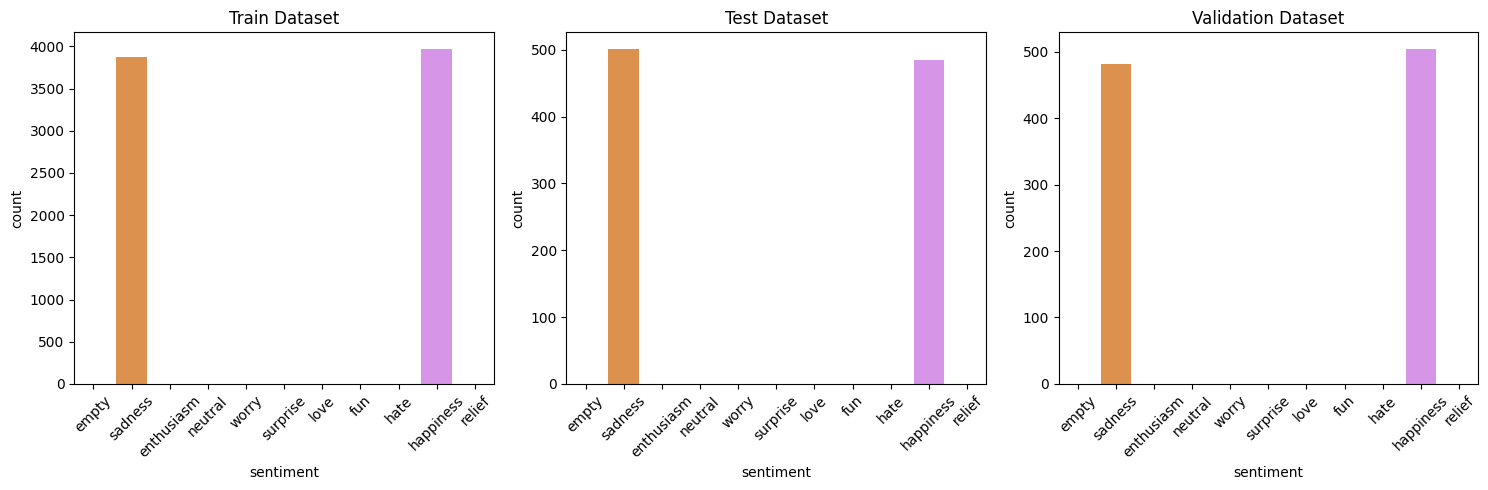

In [162]:
# Plots to see the counts for each class, Should be balanced I think...

sentiment_order = ['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'relief']

plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

# Plot for df_train
plt.subplot(131)  # 1 row, 3 columns, 1st subplot
sns.countplot(x='sentiment', data=df_train, order=sentiment_order)
plt.title("Train Dataset")
plt.xticks(rotation=45)

# Plot for df_test
plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
sns.countplot(x='sentiment', data=df_test, order=sentiment_order)
plt.title("Test Dataset")
plt.xticks(rotation=45)

# Plot for df_val
plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
sns.countplot(x='sentiment', data=df_val, order=sentiment_order)
plt.title("Validation Dataset")
plt.xticks(rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

# Draft

In [18]:
df_train.columns

Index(['preprocessed_text', 'sentiment'], dtype='object')

In [82]:
df_train.duplicated().sum(), df_test.duplicated().sum(),  df_val.duplicated().sum(),

(0, 0, 0)

In [83]:
df_train.shape, df_val.shape, df_test.shape

((27774, 2), (4650, 2), (4622, 2))

In [84]:
tf_idf = TfidfVectorizer()

In [87]:
X_train_tf = tf_idf.fit_transform(X_train).toarray()

In [89]:
X_val_tf = tf_idf.transform(X_val).toarray()
X_test_tf = tf_idf.transform(X_test).toarray()

In [90]:
X_train_tf.shape, X_val_tf.shape

((27774, 38785), (4650, 38785))

In [31]:
y_train.shape

(27773,)

In [170]:
# pip install optuna

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define hyperparameters to optimize
    C = trial.suggest_float('C', 0.001, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 50, 500)

    # Create and train the LogisticRegression model
    model = LogisticRegression(C=C, max_iter=max_iter, solver='liblinear', random_state=0)
    model.fit(X_train_tf, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val_tf)

    # Calculate the accuracy (or any other desired metric)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy  # Return the metric you want to optimize

study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=100)  # Number of trials to run

# Access the best hyperparameters and accuracy
best_params = study.best_params
best_accuracy = study.best_value
print(best_params, best_accuracy)